<a href="https://colab.research.google.com/github/snowshine/NFTCreators/blob/main/nftcreator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Google Drive Setup
for running on Google Colab only

In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

import sys
sys.path.append('/content/gdrive/MyDrive/capstone/gan/')

# change working directory to this notebook location
%cd /content/gdrive/MyDrive/capstone/gan
!ls -art

Mounted at /content/gdrive
/content/gdrive/MyDrive/capstone/gan
ganevaluation.py  dcgan.py     Blog_Input_AllenChang.ipynb
imagedata.py	  __pycache__  nftcreator.ipynb


### Imports and Computing Environment
- Included modules are in the same directory of this notebook
- Tensorflow version 2.8.0
- At least one GPU required

In [2]:
from dcgan import *
from imagedata import *
from ganevaluation import *

import tensorflow as tf
import psutil
print('Num of CPUs:', psutil.cpu_count(), "; Num of GPUs:", len(tf.config.list_physical_devices('GPU')))
print("total memory:", '{:0,.0f}'.format(psutil.virtual_memory().total), "; memory available:", '{:0,.0f}'.format(psutil.virtual_memory().available))

print('TF version:', tf.__version__, '; GPU name:', tf.test.gpu_device_name())

Num of CPUs: 4 ; Num of GPUs: 1
total memory: 27,337,134,080 ; memory available: 26,034,728,960
TF version: 2.8.0 ; GPU name: /device:GPU:0


### Setup Parameters


In [5]:
# source data parameters
# source file: <datapath>/<collection>.<datatype>
collection = "boredape"
datapath = '../data/'
outputpath = '../output/'
datatype = 'npz'  # npz, zip, or img

# image resolution and channel, 128 is the highest for CoLab (with GPU)
# support (128, 128, 3) and (32, 32, 3)
image_shape = (128, 128, 3)  

# adjust depending on size of the dataset, image resolution and computing enviornment
# tried 16, 32, 64, 128, 256, 1024
# for Colab: 128 works best for (128,128,3). 256 may work, but OOM for 20k RGB 128 collections
# smaller batch size has better performance for (32,32,3). i.e. 16(cryptopunks32), 32(hapeprime32)
batch_size = 128

# training parameters
startepoch = 0  # 0:initial training, others: continue
epochs = 100  # how many epochs to run

### Loading Data

In [6]:
imgdata = imagedata(collection, datapath)
train_dataset = imgdata.load_dataset(datatype, batch_size, image_shape)

## Model Training

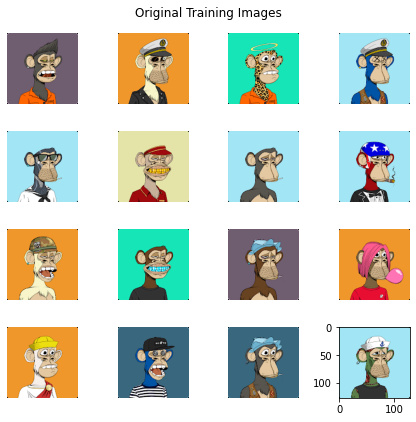

In [7]:
gan = dcgan(collection, outputpath, startepoch, image_shape)
gan.view_orig_images(train_dataset)

if startepoch > 0:
    gan.view_generated_sample()

In [ ]:
# start/continue training
gan.train(train_dataset, startepoch, epochs, batch_size)

## Model Architecture Summary

### Generator Summary

In [8]:
GENERATOR = gan.GENERATOR
DISCRIMINATOR = gan.DISCRIMINATOR

GENERATOR.summary()

Model: "Generator128x128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 256)        1048832   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 256)   

### Discriminator Summary

In [9]:
DISCRIMINATOR.summary()

Model: "Discriminator128x128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      3136      
                                                                 
 batch_normalization_6 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        65600     
                                                                 
 batch_normalization_7 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                              

### Generator Model Plot

In [10]:
# plot the model
plotfile = outputpath + collection + '/generator_plot.png'
tf.keras.utils.plot_model(GENERATOR, to_file=plotfile, show_shapes=True, show_layer_names=True, show_layer_activations=True)

### Discriminator Model Plot

In [11]:
plotfile = outputpath + collection + '/discriminator_plot.png'
tf.keras.utils.plot_model(DISCRIMINATOR, to_file=plotfile, show_shapes=True, show_layer_names=True, show_layer_activations=True)

## Model Evaluation
##### Sample from the final generator
##### Loss Charts 
##### Inception Score (IS)
- Using the pre-trained Inception v3 model to classify the generated images. 
- The score has 2 criteria for the generated images:
  - quality: how much each image looks like a known class 
  - variety: how diverse the set represent different known classes.
- A higher inception score indicates better-quality generated images.

##### Frechet Inception Distance (FID)
- Same as the inception score, the FID score also uses the inception v3 model. 
- The score calculate the distance between real images and generated images using the Frechet distance.
- A lower FID score indicates more realistic images that match the statistical properties of real images.
- FID is consistent with human judgments and is more robust to noise than IS.

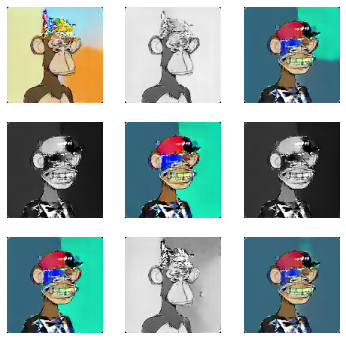

Collection: boredape  at epoch  419
IS score for original images 1.0  with std  0.0
IS score for generated images 1.0  with std  0.0
FID: 0.006


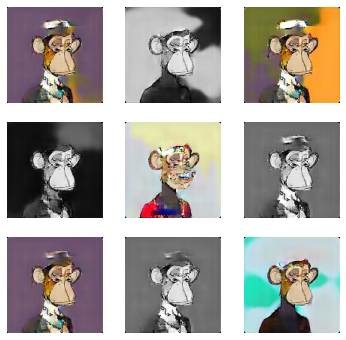

Collection: boredape  at epoch  779
IS score for original images 1.0  with std  0.0
IS score for generated images 1.0  with std  0.0
FID: 0.001


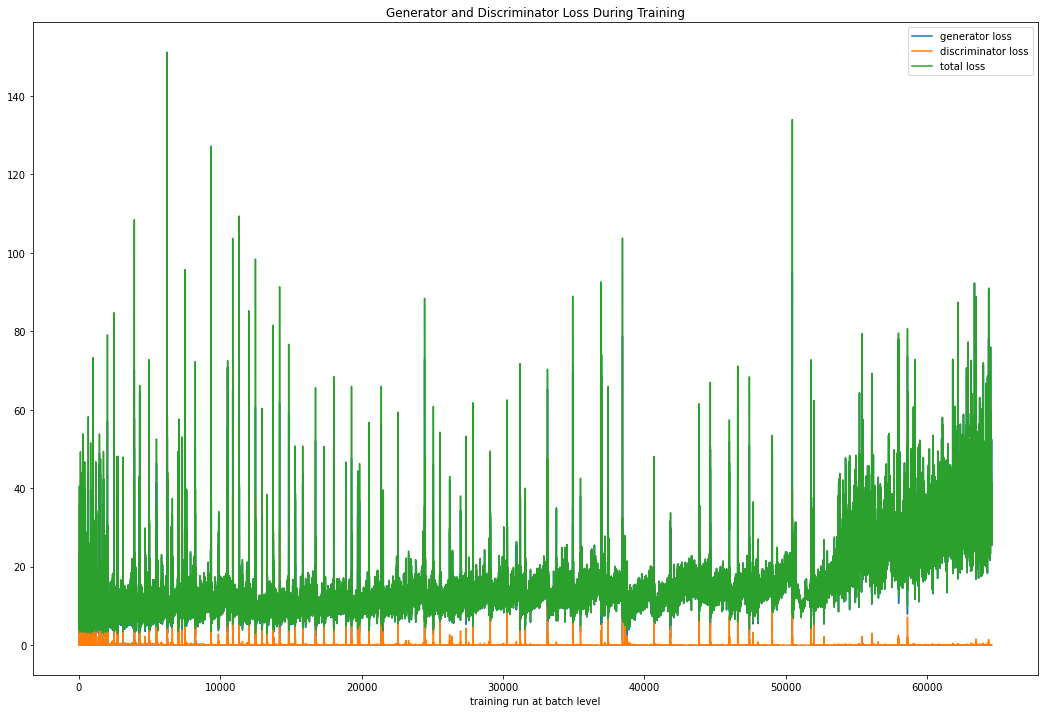

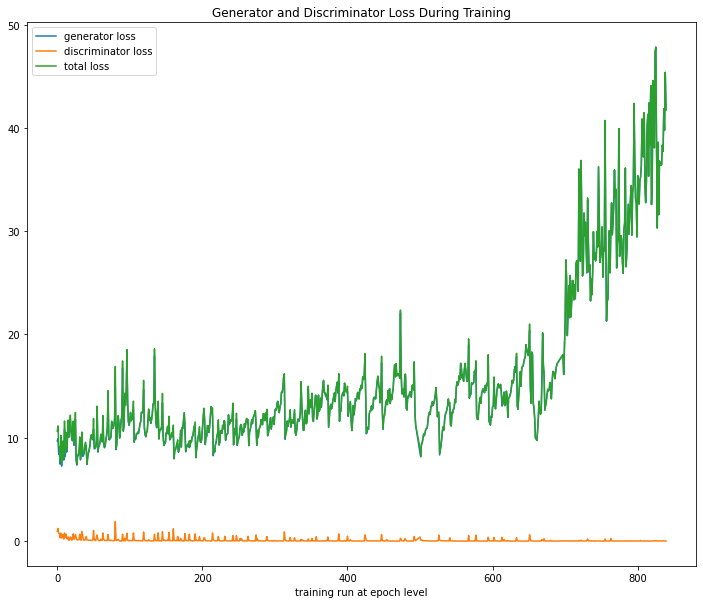

In [13]:
# evaluate each saved generators
# normally start after 100 epoch when generated images showing something
startepoch = 719
# endepoch is the total epochs
# endepoch = epochs
endepoch = 839

# generator_epoch = range(startepoch,endepoch + 1,15)
generator_epoch = [419, 779]

# Evaluations
ganeval = ganevaluation(collection, datapath, outputpath)

# manual evaluation of generated images as well as IS and FID scores
for epoch in generator_epoch:
  o_is_avg, o_is_std, g_is_avg, g_is_std, fid = ganeval.evaluate_epoch(epoch)
  print('Collection:', collection, ' at epoch ', epoch)
  print('IS score for original images', o_is_avg, ' with std ', o_is_std)
  print('IS score for generated images', g_is_avg, ' with std ', g_is_std)
  print('FID: %.3f' % fid)

# display training loss metrics, both batch and epoch level
ganeval.loss_metrics_chart('batch')
ganeval.loss_metrics_chart('epoch')

## Best Practice and Challenges

#### Best Practice Followed

Model:
- Using Strided Convolutions for Downsample and Upsample instead of pooling
- Adding Gaussian Weight Initial noise to every layer of generator
- Using Batch Normalization
- Using LeakyReLU instead of ReLU, with a default slope of 0.2
- Using Dropout in descriminator (and generator?)
- use the tanh activation function to ensure generator output range [-1,1]

Optimizer:
- Using the Adam version of stochastic gradient descent (SGD) 
- Using Two Time-Scale Update Rule (TTUR): 
  - different learning rates for generator and discriminator
  - tuning learning rate, start with 0.0002
  - Using beta1 momentum of 0.5 instead of the default of 0.9

Training Process
- Scale/normalize images from [0,255] to the range [-1,1]
- Using Tanh as the last layer of the generator to output [-1,1]
- Train the discriminator with separate batches of real and fake images
- Using one-sided Label Smoothing to tune down discriminator to avoid overconfidence





#### Challenges

some of the well-known challenges:

- Non-convergence
  - No objective loss function for the GAN model overall performance    
    - The losses of Descriminator and Generator are measured individually
    - can't determine the relative/absolute GAN model quality from loss alone  
    - no way to objectively assess the progress of the training 
  - model is “good” when an equilibrium is reached between G and D 
    - typically when the discriminator’s loss is around 0.5
  - Training for a long time doesn’t always make the generator better, may worse
  - When D loss goes to 0, that's the failure mode
  - if loss of generator steadily decreases, then it's fooling D with garbage (says martin)  
  - Vanishing Gradients
  - 
- Mode collapse
  - generator produces the same or a small subset of the images repeatedly.
  
- Difficult to evaluate
  - In general no objective ways to evaluate the GAN performance
  - Subjective evaluation or manual inspection of generated images
  - Quantitative measures can be combined with qualitative assessment
    - the inception score
    - the Frechet inception distance

- Computing Environment
  - Colab(free): OOM at batch size 256
    - only when GPU available: batch size 128, run_time=0:02:22.20 per epoch
  - Colab pro: 
    - TPU: OOM at batch size 1024; batch size 512, run_time=0:30:27.46 per epoch
    - GPU: OOM at batch size 256;  batch size 128, run_time=0:01:31.42 per epoch